In [1]:
import numpy as np 
import pandas as pd 
from pandas import Series

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

### Функции

In [5]:
def outliers_iqr(s):
    q1, q3 = np.percentile(s, [25, 75])
    iqr = q3 - q1
    lower = q1 - (iqr * 1.5)
    upper = q3 + (iqr * 1.5)
    return lower, upper, iqr

# визуальзация числовых признаков и выбросы
def visual_num(data, col, size=6):
    fig, (g1, g2) = plt.subplots(1, 2, figsize=(2*size, size))
    fig.suptitle(
        'Гисторгамма и boxplot для {0} по default'.format(col), fontsize=20)
    g1.hist(data[col], bins=20, histtype='bar', align='mid',
            rwidth=0.8)
    g2.boxplot([data[data.default == 0][col], data[data.default == 1][col]])
    plt.figtext(0.5, 0, col, fontsize=16)
    plt.xticks([1, 2], ["0", "1"])
    plt.show


def outliers(data, col):
    l, r, iqr = outliers_iqr(data[col])

    out = (data[col] > r).sum() + (data[col] < l).sum()
    out_percent = round(
        out/data[col].count()*100, 1
    )

    print(f'----------------> {col} <----------------')
    print(f'IQR: {iqr}, границы выбросов: [{l}, {r}]')
    print(f'Всего {out} ({out_percent}%) выбросов')


# Таблица метрик для сравнения результатов каждой модели
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'ROC_AUC']

# Добавляем метрики в общую таблицу
def summary_metrics(summary, col, y_valid, y_pred, y_pred_probs):
    values = [accuracy_score(y_valid, y_pred), precision_score(y_valid, y_pred), recall_score(
        y_valid, y_pred), f1_score(y_valid, y_pred), roc_auc_score(y_valid, y_pred_probs)]
    summary[col] = values
    return summary


# кривая ROC_AUC
def roc_auc_curve(y_valid, y_pred_probs):
    fpr, tpr, threshold = roc_curve(y_valid, y_pred_probs)
    roc_auc = roc_auc_score(y_valid, y_pred_probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# визуализация confusion matrix
def conf_mat(y_valid, y_pred):
    cm = confusion_matrix(y_valid, y_pred)

    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cm.flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in
              zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
    plt.show()

### Загрузка датасета

In [7]:
path_to_data = './'
#path_to_data = '/kaggle/input/sf-dst-scoring/'

# Импорт и просмотр данных
df_train = pd.read_csv(path_to_data + 'train.csv')
df_test = pd.read_csv(path_to_data + 'test.csv')
sample_submission = pd.read_csv(path_to_data + 'sample_submission.csv')

print('df_train:', df_train.shape)
print('df_test:', df_test.shape)
print('diff:', set(df_train.columns) - set(df_test.columns))
print('\ndata:')
display(df_train.info())
display(df_train.head(2))
print('submission:')
display(sample_submission.info())
display(sample_submission.head(2))

df_train: (73799, 19)
df_test: (36349, 18)
diff: {'default'}

data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               7

None

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


submission:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


None

,client_id,default
0,66799,0.441004
1,25379,0.138092


In [8]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

### Работа с пропусками

In [9]:
df_train.isnull().sum(), df_test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

In [10]:
display(df_train.education.value_counts(normalize=True, dropna=False))
display(df_test.education.value_counts(normalize=True, dropna=False))

SCH    0.526565
GRD    0.316603
UGR    0.133010
PGR    0.017033
NaN    0.004160
ACD    0.002629
Name: education, dtype: float64

SCH    0.526507
GRD    0.313709
UGR    0.135685
PGR    0.016727
NaN    0.004704
ACD    0.002669
Name: education, dtype: float64

#### Пропуски только в *education* и их мало. Заполним их наиболее частыми значениями

In [11]:
df_train.education.fillna(
    df_train.education.mode()[0],
    inplace=True
)
df_test.education.fillna(
    df_test.education.mode()[0],
    inplace=True
)

### Feature engineering

#### Посмотрим на app_date

In [12]:
df_train.app_date.head(2), df_test.app_date.head(2)

(0    01FEB2014
 1    12MAR2014
 Name: app_date, dtype: object,
 0    22MAR2014
 1    24JAN2014
 Name: app_date, dtype: object)

In [13]:
# Сконветируем в формат даты
df_train.app_date = pd.to_datetime(df_train.app_date)
df_test.app_date = pd.to_datetime(df_test.app_date)
df_train.app_date.head(2), df_test.app_date.head(2)

(0   2014-02-01
 1   2014-03-12
 Name: app_date, dtype: datetime64[ns],
 0   2014-03-22
 1   2014-01-24
 Name: app_date, dtype: datetime64[ns])

#### Сделаем новый признак - количество дней до сегодняшнего числа

In [14]:
today = pd.to_datetime('15MAR2021')
df_train['days'] = (today - df_train.app_date).dt.days
df_test['days'] = (today - df_test.app_date).dt.days

#### Разделим колонки по типам данным

In [15]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']
num_cols = ['days', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']

#### Посмотрим на целевую переменную

In [16]:
df_train['default'].value_counts(normalize=True, dropna=False)

0    0.873006
1    0.126994
Name: default, dtype: float64

 #### Распределение неравномерное, недефолтных клиентов заметно больше. Применим oversamping - кратно увеличим default-ных копированием

In [17]:
mult = int(
    df_train[df_train.default == 0].default.shape[0] /
    df_train[df_train.default == 1].default.shape[0]
)
mult

6

In [18]:
df_train_1 = df_train[df_train.default == 1]
for _ in range(mult):
    df_train = df_train.append(df_train_1).reset_index(drop=True)

#### Результат

In [19]:
df_train['default'].value_counts(normalize=True, dropna=False)

1    0.504526
0    0.495474
Name: default, dtype: float64

### Смотрим на выбросы в числовых признаках

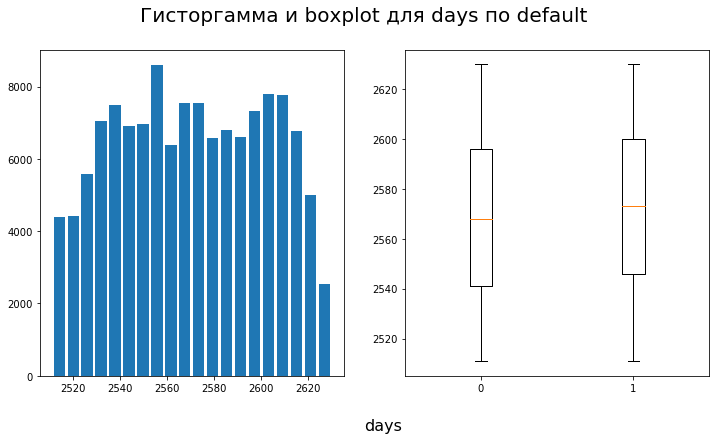

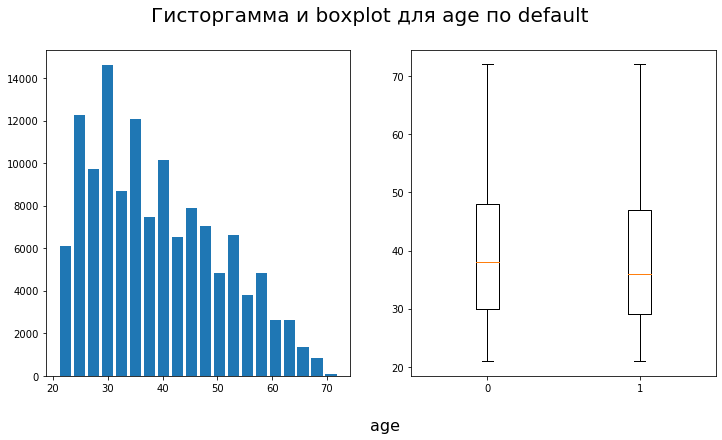

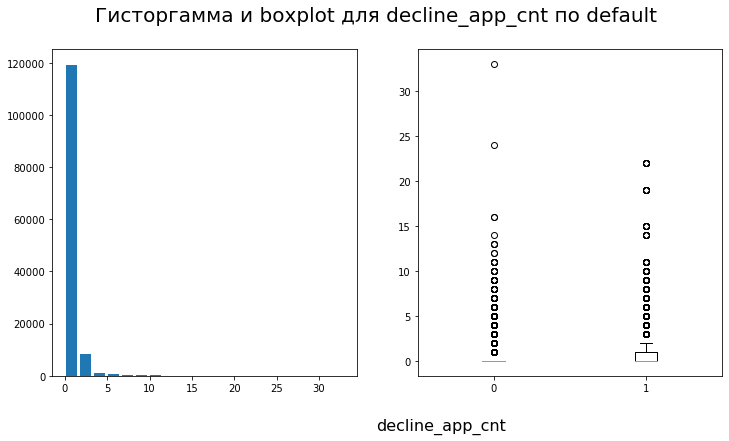

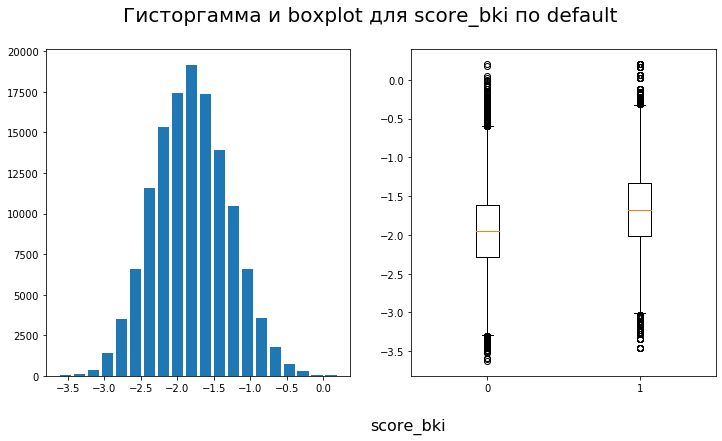

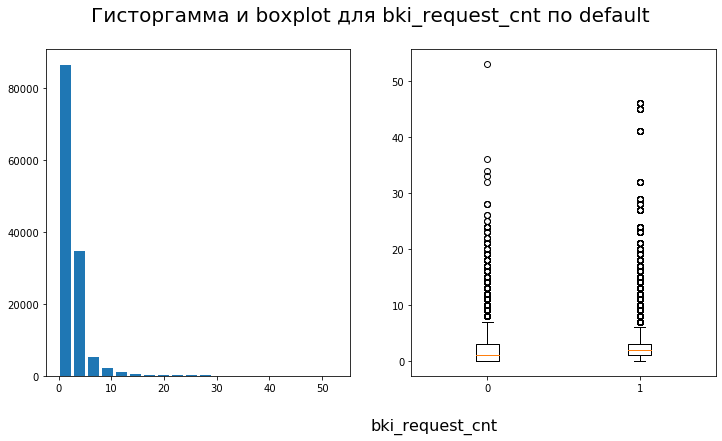

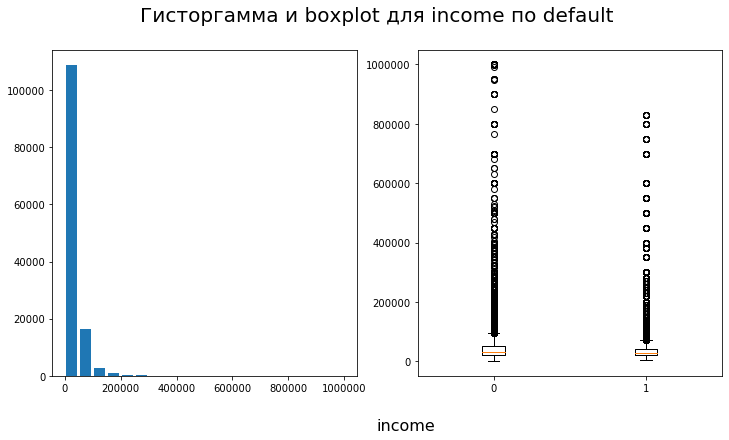

In [20]:
for col in num_cols:
    visual_num(df_train, col)

In [21]:
for col in num_cols:
    outliers(df_train, col)

----------------> days <----------------
IQR: 54.0, границы выбросов: [2463.0, 2679.0]
Всего 0 (0.0%) выбросов
----------------> age <----------------
IQR: 18.0, границы выбросов: [2.0, 74.0]
Всего 0 (0.0%) выбросов
----------------> decline_app_cnt <----------------
IQR: 0.0, границы выбросов: [0.0, 0.0]
Всего 28587 (22.0%) выбросов
----------------> score_bki <----------------
IQR: 0.7081654850000001, границы выбросов: [-3.2317855925, -0.3991236524999999]
Всего 555 (0.4%) выбросов
----------------> bki_request_cnt <----------------
IQR: 2.0, границы выбросов: [-2.0, 6.0]
Всего 5715 (4.4%) выбросов
----------------> income <----------------
IQR: 25000.0, границы выбросов: [-17500.0, 82500.0]
Всего 8361 (6.4%) выбросов


У *age* и *days* выбросов нет, ничего не делаем.

У *decline_app_cnt* есть выбросы, но их удалять не нужно, т.к. медиана практически 0, после удаления весь этот признак обратится в 0 -- может плохо сказаться на модели.

У *score_bki*, *bki_request_cnt* и *income* есть выбросы, можно убрать.

In [22]:
# убираем выбросы в выбранных численных столбцах
num_cols_outliers = ['bki_request_cnt', 'score_bki', 'income']
for col in num_cols_outliers:
    d = outliers_iqr(df_train[col])
    df_train = df_train.loc[df_train[col].between(d[0], d[1])]

#### Прологарифмируем переменные, распределение которых смещено влево

In [23]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for col in num_cols_log:
    df_train[col] = np.log(df_train[col] + 1)

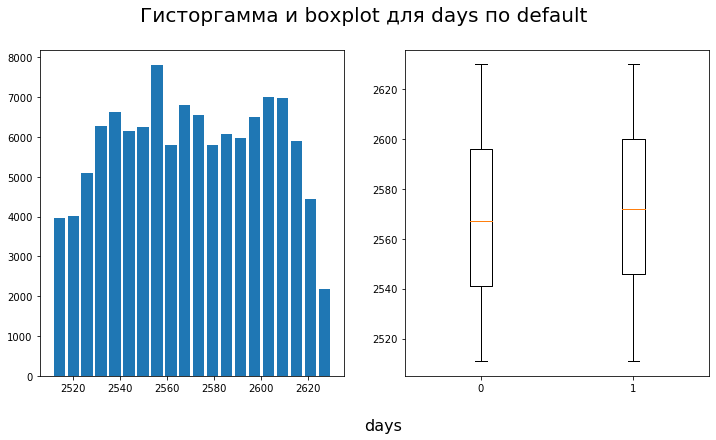

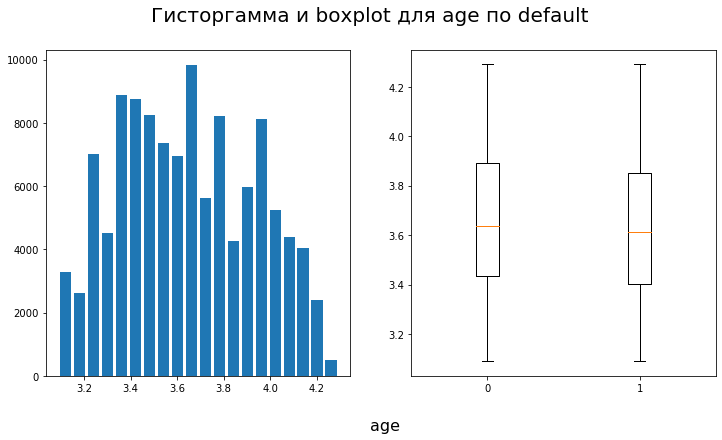

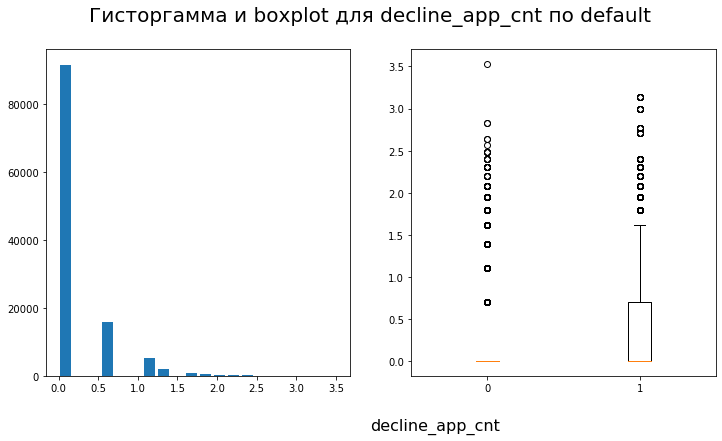

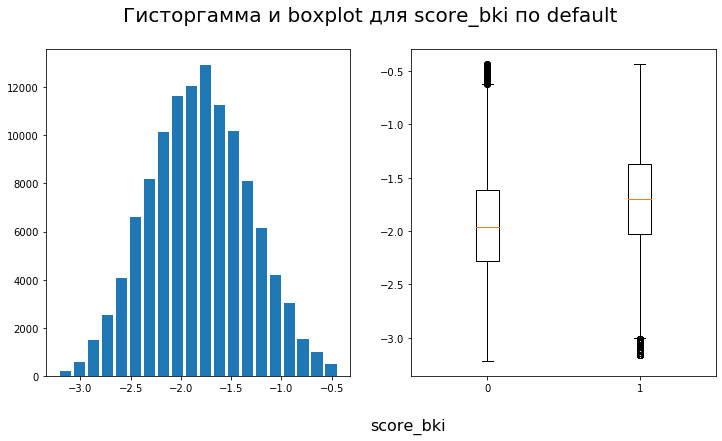

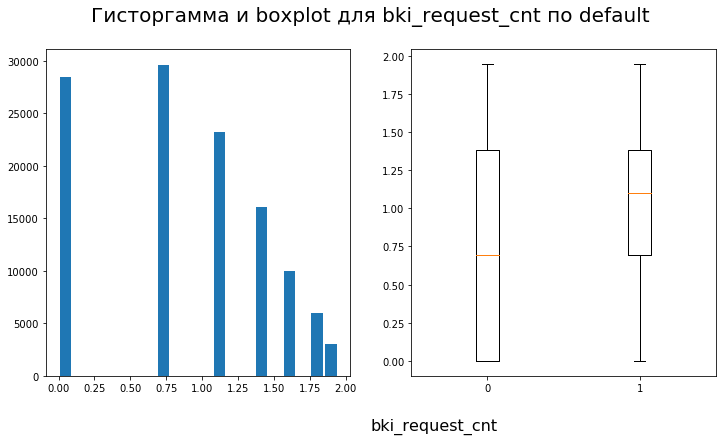

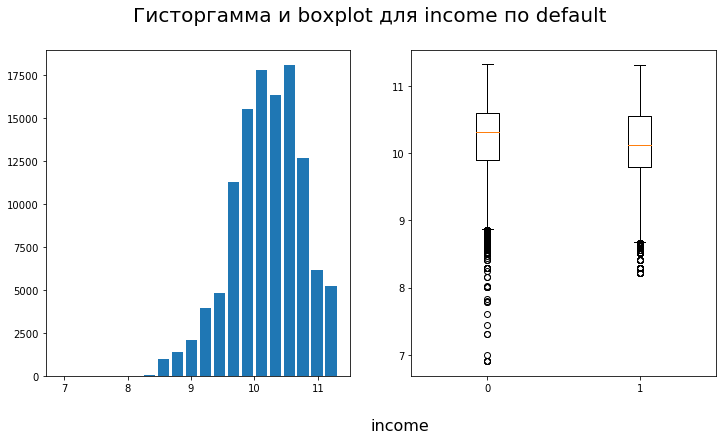

In [24]:
# результат
for col in num_cols:
    visual_num(df_train, col)

In [25]:
# Прологарифмируем так же для теста
for col in num_cols_log:
    df_test[col] = np.log(df_test[col] + 1)

In [26]:
corr = df_train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(3)

,days,age,decline_app_cnt,score_bki,bki_request_cnt,income
days,1.000,-0.021,0.020,0.058,-0.008,-0.007
age,-0.021,1.000,-0.153,-0.110,0.046,-0.159
decline_app_cnt,0.020,-0.153,1.000,0.213,0.077,0.007
score_bki,0.058,-0.110,0.213,1.000,0.105,0.001
bki_request_cnt,-0.008,0.046,0.077,0.105,1.000,0.054
income,-0.007,-0.159,0.007,0.001,0.054,1.000


#### Высокой корреляции между признаками не наблюдается

### Преобразование бинарных и категориальных переменных

In [27]:
# Преобразуем бинарные переменные при помощи класса LabelEncoder
label_encoder = LabelEncoder()

for column in bin_cols:
    df_train[column] = label_encoder.fit_transform(df_train[column])
    df_test[column] = label_encoder.fit_transform(df_test[column])

display(df_train.head(2))
display(df_test.head(3))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.0,0,-2.008753,0.693147,50,1,2,9.798183,4,1,0,0,2599
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.0,0,-1.532276,1.386294,50,2,3,9.852247,4,1,0,0,2560


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days
0,74835,2014-03-22,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,2550
1,17527,2014-01-24,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,2607
2,75683,2014-03-23,UGR,1,3.931826,1,1,0.000000,0,-1.691339,0.693147,50,1,2,10.308986,1,3,1,2549


In [28]:
# Сделаем dummy из всех категориальных признаков
df_train = pd.get_dummies(df_train, columns=cat_cols)
df_test = pd.get_dummies(df_test, columns=cat_cols)

In [29]:
# Новый список категориальных признаков
cat_cols_dummies = [c1 for c in cat_cols for c1 in df_train.columns if c1.startswith(c)]

### Значимость непрерывных числовых признаков¶

Text(0.5, 0, 'F-value')

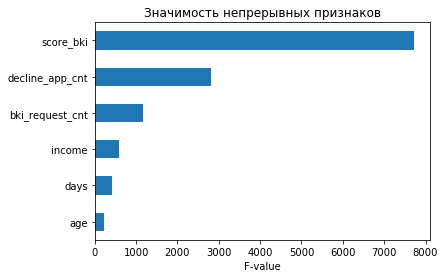

In [30]:
imp_num = Series(f_classif(df_train[num_cols], df_train.default)[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость непрерывных признаков')
plt.xlabel('F-value')

### Значимость бинарных признаков

Text(0.5, 1.0, 'Значимость бинарных признаков')

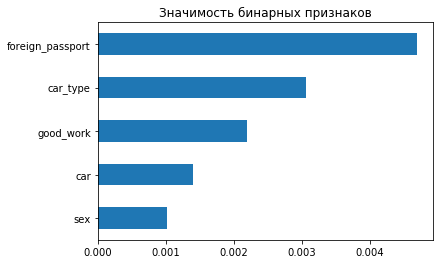

In [31]:
# Значимость бинарных признаков
imp_bin = Series(mutual_info_classif(df_train[bin_cols],
                                     df_train.default,
                                     discrete_features=True),
                 index=bin_cols)
imp_bin.sort_values(inplace=True)
imp_bin.plot(kind='barh')
plt.title('Значимость бинарных признаков')

### Значимость категориальных признаков

Text(0.5, 1.0, 'Значимость категорисльных признаков')

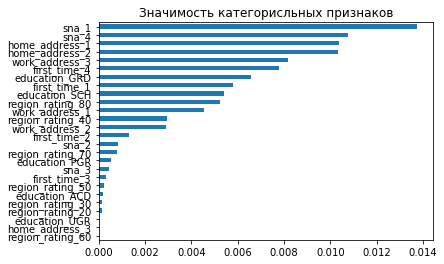

In [32]:
imp_cat = pd.Series(mutual_info_classif(df_train[cat_cols_dummies],
                                        df_train.default,
                                        discrete_features=True),
                    index=cat_cols_dummies)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Значимость категорисльных признаков')

### Подготовка данных к обучению

In [33]:
# Сгенерируем полиномальные признаки из числовых
poly = PolynomialFeatures(2)

x_poly_train = poly.fit_transform(df_train[num_cols].values)
x_poly_test = poly.fit_transform(df_test[num_cols].values)

In [34]:
# Стандартизация числовых переменных
X_num_train = StandardScaler().fit_transform(x_poly_train)
X_num_test = StandardScaler().fit_transform(x_poly_test)

In [35]:
X_num_train.shape, X_num_test.shape

((116262, 28), (36349, 28))

#### Объединим все в одно пространство.

In [36]:
X = np.hstack([X_num_train, df_train[bin_cols].values, df_train[cat_cols_dummies].values])
Y = df_train.default.values

X_ids_test = np.hstack([X_num_test, df_test[bin_cols].values,  df_test[cat_cols_dummies].values])
ids_test = df_test.client_id

In [37]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, Y,
    test_size=0.20,
    random_state=RANDOM_SEED,
    shuffle=True
)

In [38]:
# База с метриками
summary = pd.DataFrame(index=metrics)

### Первое обучение

In [39]:
model = LogisticRegression(random_state=RANDOM_SEED, max_iter = 1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [40]:
probs = model.predict_proba(X_valid)
y_pred_probs = probs[:,1]

y_pred = model.predict(X_valid)

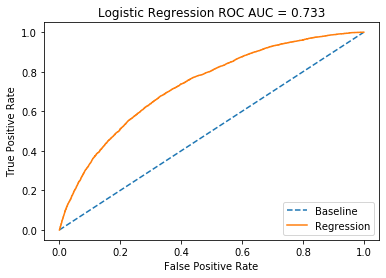

In [41]:
roc_auc_curve(y_valid, y_pred_probs)

In [42]:
summary_metrics(summary, 'model_1', y_valid, y_pred, y_pred_probs)

,model_1
accuracy,0.671182
precision,0.666500
recall,0.686770
f1_score,0.676483
ROC_AUC,0.732702


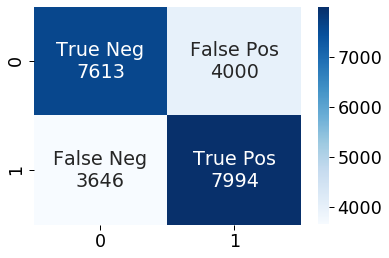

In [43]:
conf_mat(y_valid, y_pred)

### Подбор гиперпараметров (регуляризация)

In [44]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 10000.0


### Обучение после регуляризации

In [53]:
model = LogisticRegression(
    penalty=best_model.best_estimator_.get_params()['penalty'],
    C=best_model.best_estimator_.get_params()['C'],
    max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=10000.0, max_iter=1000)

In [54]:
probs = model.predict_proba(X_valid)
y_pred_probs = probs[:,1]

y_pred = model.predict(X_valid)

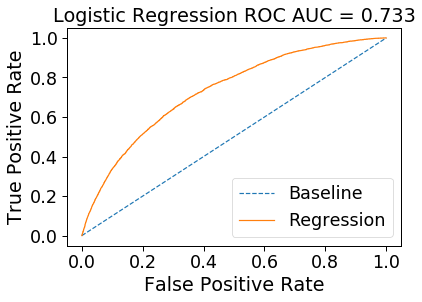

In [55]:
roc_auc_curve(y_valid, y_pred_probs)

In [48]:
summary_metrics(summary, 'model_2', y_valid, y_pred, y_pred_probs)

,model_1,model_2
accuracy,0.671182,0.672042
precision,0.666500,0.667473
recall,0.686770,0.687199
f1_score,0.676483,0.677193
ROC_AUC,0.732702,0.732816


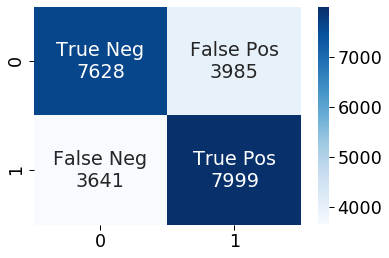

In [49]:
conf_mat(y_valid, y_pred)

### Предсказываем и сохраняем submission

In [ ]:
model = LogisticRegression(
    penalty=best_model.best_estimator_.get_params()['penalty'],
    C=best_model.best_estimator_.get_params()['C'],
    max_iter=1000)
model.fit(X, Y)
probs = model.predict_proba(X_ids_test)
probs = probs[:, 1]

In [ ]:
my_submission = pd.DataFrame({'client_id': ids_test,
                              'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission.head(10)